# Dataproc Workflow jobs analysis

* This code will not run incrementally, but historically
* Tables will be recreated at each run

### 1. Install upgrade dependencies

In [ ]:
pip install google-cloud-dataproc

In [ ]:
pip install --upgrade google-api-core

##### 1.1 RESTART KERNEL

### 2. Variables and imports

In [23]:
from google.cloud import dataproc_v1 as dataproc
from google.api_core import client_options
from google.longrunning.operations_pb2 import ListOperationsRequest
from typing import Sequence, Tuple, Union
from google.protobuf.json_format import MessageToJson 
import json
import pandas as pd
from google.cloud import bigquery

In [2]:
PROJECT_ID = "YOUR_PROJECT_ID"
GCP_REGION = "us-central1"
BQ_DATASET_NAME = "dataproc_analysis"
BQ_TABLE_NAME_RAW = "operations_raw"
BQ_TABLE_NAME_CLEAN = "operations_clean"
BQ_TABLE_NAME_MODEL = "operations_model"
BQ_BILLING_DATASET_NAME = "gcp_billing"
BQ_BILLING_TABLE_NAME = "gcp_billing_export_resource_v1_019CAE_7D7330_15385C"

In [24]:
client_options = client_options.ClientOptions(
    api_endpoint=f"{GCP_REGION}-dataproc.googleapis.com:443"
)
workflow_template_client = dataproc.WorkflowTemplateServiceClient(client_options=client_options)
bq_client = bigquery.Client()

In [25]:
def run_bq_query(sql_query):
    query_job = bq_client.query(sql_query)
    return query_job.result()

In [26]:
def save_to_bq(table_id, df, schema = None):
    job_config = bigquery.LoadJobConfig(
        write_disposition="WRITE_APPEND",
        schema = schema
    )

    job = bq_client.load_table_from_dataframe(df, table_id, job_config=job_config) 
    return job.result()

In [160]:
SQL_QUERY = f"""
    CREATE OR REPLACE TABLE {BQ_DATASET_NAME}.{BQ_TABLE_NAME_RAW}
    (
        clusterUuid STRING,
        clusterName STRING,
        operationType STRING,
        status STRING,
        statusHistory STRING
    );
    CREATE OR REPLACE TABLE {BQ_DATASET_NAME}.{BQ_TABLE_NAME_CLEAN}
    (
        clusterUuid STRING, 
        clusterName STRING,
        operationType STRING,
        stateStartTime STRING
    );
    CREATE OR REPLACE TABLE {BQ_DATASET_NAME}.{BQ_TABLE_NAME_MODEL}
    (
        clusterUuid STRING, 
        clusterName STRING,
        created TIMESTAMP,
        deleted TIMESTAMP,
        seconds_elapsed INTEGER,
        date DATE,
        hour INTEGER
    );
"""
run_bq_query(SQL_QUERY)

### 3. List workflow templates

In [28]:
parent = f"projects/{PROJECT_ID}/regions/{GCP_REGION}"
request = dataproc.ListWorkflowTemplatesRequest(parent=parent)

In [29]:
page_result = workflow_template_client.list_workflow_templates(request=request)

In [30]:
workflow_templates = []

for response in page_result:
    workflow_templates.append({
        "name": response.name,
        "id": response.id
    })
    
workflow_templates

[{'name': 'projects/lgbaeza-202310/regions/us-central1/workflowTemplates/template-0d563',
  'id': 'template-0d563'},
 {'name': 'projects/lgbaeza-202310/regions/us-central1/workflowTemplates/template-27b5c',
  'id': 'template-27b5c'},
 {'name': 'projects/lgbaeza-202310/regions/us-central1/workflowTemplates/template-2fd78',
  'id': 'template-2fd78'},
 {'name': 'projects/lgbaeza-202310/regions/us-central1/workflowTemplates/template-702fa',
  'id': 'template-702fa'}]

### 4. Get cluster operations and save them into BigQuery

In [157]:
def run_extract(filter_string):
    operations_count = 0
    page_token = ""
    while True:
        operations = []
        request = ListOperationsRequest(
            name = parent,
            page_token = page_token,
            filter = filter_string
        )
        execution_request = workflow_template_client.list_operations(request=request)
        for ops in execution_request.operations:
            if ops.metadata.type_url == "type.googleapis.com/google.cloud.dataproc.v1.ClusterOperationMetadata":
                operations_count += 1
                cluster_metadata = json.loads(MessageToJson(ops.metadata))
                operations.append(cluster_metadata)

        df = pd.DataFrame(operations)
        df = df.explode("statusHistory")
        df["statusHistory"] = df["statusHistory"].apply(json.dumps)
        df["status"] = df["status"].apply(json.dumps)
        save_to_bq(
            table_id = f"{BQ_DATASET_NAME}.{BQ_TABLE_NAME_RAW}",
            df = df[["clusterName", "clusterUuid", "operationType", "statusHistory", "status"]]
        )

        page_token = execution_request.next_page_token
        if page_token == '':
            return operations_count

In [161]:
operations_count = 0
filter_string = "operationType=CREATE"

operations_count += run_extract(filter_string)

filter_string = "operationType=DELETE"
operations_count += run_extract(filter_string)

In [162]:
f"{operations_count} operations found"

'84 operations found'

#### 5. Clean operations

In [163]:
SQL_QUERY = f"""
    INSERT INTO {BQ_DATASET_NAME}.{BQ_TABLE_NAME_CLEAN}
      WITH operations_clean AS (
        SELECT 
            clusterUuid
            , clusterName
            , operationType
            , JSON_VALUE(PARSE_JSON(status), '$.state') state
            , JSON_VALUE(PARSE_JSON(status), '$.stateStartTime') stateStartTime
          FROM {BQ_DATASET_NAME}.{BQ_TABLE_NAME_RAW}
      )
      , created AS (
        SELECT
        *
        , RANK() OVER ( PARTITION BY clusterUuid ORDER BY stateStartTime ASC) cluster_group
        FROM operations_clean 
        WHERE operationType = 'CREATE'
        GROUP BY 1,2,3,4,5
        ORDER BY stateStartTime
      )
      , deleted AS (
        SELECT
        *
        , RANK() OVER ( PARTITION BY clusterUuid ORDER BY stateStartTime DESC ) cluster_group
        FROM operations_clean 
        WHERE operationType = 'DELETE'
        GROUP BY 1,2,3,4,5
        ORDER BY stateStartTime
      )
      SELECT clusterUuid, clusterName, operationType, stateStartTime from created
      WHERE cluster_group = 1
      UNION ALL
      SELECT clusterUuid, clusterName, operationType, stateStartTime from deleted
      WHERE cluster_group = 1
"""
run_bq_query(SQL_QUERY)

### 6. Model cluster usage

In [164]:
SQL_QUERY = f"""
    INSERT INTO {BQ_DATASET_NAME}.{BQ_TABLE_NAME_MODEL}
        WITH cluster_create AS (
          SELECT clusterUuid, clusterName, TIMESTAMP(stateStartTime) stateStartTime
          FROM {BQ_DATASET_NAME}.{BQ_TABLE_NAME_CLEAN}
          WHERE operationType = 'CREATE'
        )
        , cluster_delete AS (
          SELECT clusterUuid, TIMESTAMP(stateStartTime) stateStartTime
          FROM {BQ_DATASET_NAME}.{BQ_TABLE_NAME_CLEAN}
          WHERE operationType = 'DELETE'
        )
        SELECT 
            cluster_create.clusterUuid
          , cluster_create.clusterName
          , cluster_create.stateStartTime AS created
          , cluster_delete.stateStartTime AS deleted
          , TIMESTAMP_DIFF(cluster_delete.stateStartTime, cluster_create.stateStartTime, SECOND) AS seconds_elapsed
          , extract(DATE from cluster_create.stateStartTime) date
          , extract(HOUR from cluster_create.stateStartTime) hour
         FROM cluster_create
        LEFT JOIN cluster_delete
        USING (clusterUuid)
        GROUP BY 1,2,3,4
"""
run_bq_query(SQL_QUERY)

#### 7. Visualize

#### 7.1 Total seconds by time

In [167]:
SQL_QUERY = f"""
    SELECT 
          date
        , hour
        , concat(date, ' ', hour, ':00') date_hour
        , sum(seconds_elapsed) / 60 minutes
    FROM {BQ_DATASET_NAME}.{BQ_TABLE_NAME_MODEL}
    GROUP BY 1,2,3
    ORDER BY 3
"""
df = bq_client.query(SQL_QUERY).to_dataframe()

<Axes: xlabel='date_hour'>

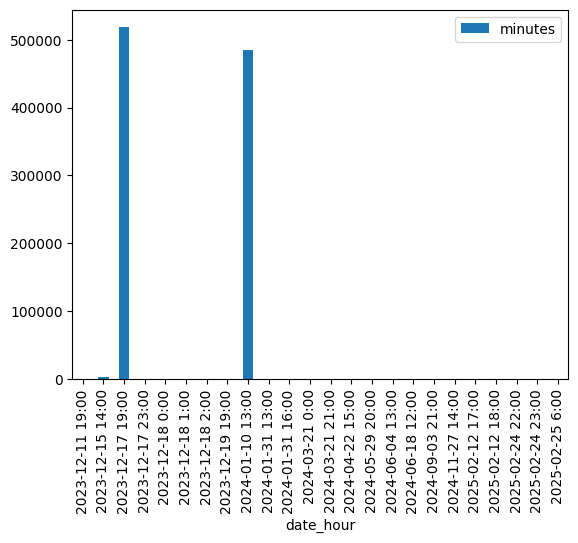

In [168]:
df.plot(kind="bar", x="date_hour", y="minutes")

#### 7.2 Cluster details

In [169]:
SQL_QUERY = f"""
SELECT 
      date
    , hour
    , clusterUuid
    , clusterName
    , seconds_elapsed / 60 minutes
FROM {BQ_DATASET_NAME}.{BQ_TABLE_NAME_MODEL}
ORDER BY 1,2,3
"""
df = bq_client.query(SQL_QUERY).to_dataframe()

In [170]:
df.head()

,date,hour,clusterUuid,clusterName,minutes
0,2023-12-11,19,b82c4657-f903-4d23-bed3-0339fd2bd9c6,cluster-1b43,2.116667
1,2023-12-15,14,4fb421fd-38ec-40c8-9854-e8a9b31be49b,cluster-7b75,3228.850000
2,2023-12-17,19,6e1240ed-35b8-4a76-b513-a14ff3d2a18c,cluster-7b75,518361.416667
3,2023-12-17,23,2de8191e-7e85-447c-986d-ab55058b9c84,srvls-session-0bd5fe97-3fb6-4f84-822a-80615c90...,0.066667
4,2023-12-17,23,579c8426-e0d0-4797-b89e-91c8b9b1fba4,srvls-session-0db2a939-2ac6-43cf-8ed4-adb38985...,0.066667


### 8. Billing information

#### 8.1 Total price

In [176]:
SQL_QUERY = f"""
    SELECT 
      CONCAT(
          EXTRACT (DATE FROM usage_start_time),
          ' ',
          EXTRACT (HOUR FROM usage_start_time),
          ' :00'
       ) date_hour,
      sku.id sku_id, 
      price.effective_price / price.pricing_unit_quantity effective_price,
      SUM(usage.amount_in_pricing_units) amount_in_pricing_units, 
      SUM(usage.amount_in_pricing_units * price.effective_price / price.pricing_unit_quantity) total_price
    FROM {BQ_BILLING_DATASET_NAME}.{BQ_BILLING_TABLE_NAME}
    WHERE 
      service.description = 'Dataproc' 
      AND sku.description LIKE 'Data Compute Unit (milli) Hours%'
    GROUP BY 1,2,3
    ORDER BY 1
"""
df_billing = bq_client.query(SQL_QUERY).to_dataframe()

<Axes: xlabel='date_hour'>

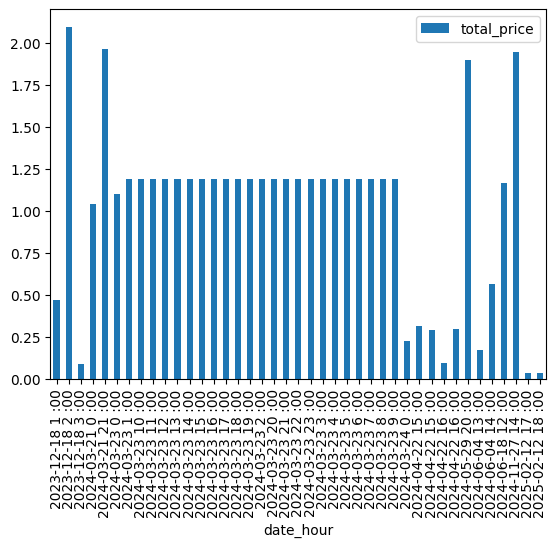

In [177]:
df_billing.plot(kind="bar", x="date_hour", y="total_price")

#### 8.2 Billing detail

In [178]:
SQL_QUERY = f"""
    SELECT 
      EXTRACT (DATE FROM usage_start_time) date,
      EXTRACT (HOUR FROM usage_start_time) hour,
      sku.id sku_id, 
      price.effective_price / price.pricing_unit_quantity effective_price,
      SUM(usage.amount_in_pricing_units) amount_in_pricing_units, 
      SUM(usage.amount_in_pricing_units * price.effective_price / price.pricing_unit_quantity) total_price
    FROM {BQ_BILLING_DATASET_NAME}.{BQ_BILLING_TABLE_NAME}
    WHERE 
      service.description = 'Dataproc' 
      AND sku.description LIKE 'Data Compute Unit (milli) Hours%'
    GROUP BY 1,2,3,4
    ORDER BY 1,2
"""
df_billing = bq_client.query(SQL_QUERY).to_dataframe()

In [179]:
df_billing.head()

,date,hour,sku_id,effective_price,amount_in_pricing_units,total_price
0,2023-12-18,1,A486-6040-07FE,0.000089000,5270.261389,0.469053
1,2023-12-18,2,A486-6040-07FE,0.000089000,23522.042778,2.093462
2,2023-12-18,3,A486-6040-07FE,0.000089000,992.728333,0.088353
3,2024-03-21,0,A486-6040-07FE,0.000089000,11721.573333,1.043220
4,2024-03-21,21,A486-6040-07FE,0.000089000,22043.298611,1.961854
